In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from glob import glob
from IPython import get_ipython

ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']
nb_name = os.path.basename(path)

nb_remote_path = [os.path.abspath(y) for x in os.walk('.') for y in glob(os.path.join(x[0], '*.ipynb')) if nb_name in y][0]
os.chdir(os.path.dirname(nb_remote_path))
print(os.getcwd())
current_path = os.path.abspath('..')
if current_path not in sys.path:
    sys.path.insert(0, os.path.abspath('..'))
    sys.path.insert(0, os.path.join(os.path.abspath('..'), '..'))
    sys.path.insert(0, os.path.join(os.path.abspath('..'), '..', '..'))
    print(sys.path)

/Users/yinnnyou/workspace/medical_imaging_imbalancing/src/cifar_100
['/Users/yinnnyou/workspace/medical_imaging_imbalancing/src/../..', '/Users/yinnnyou/workspace/medical_imaging_imbalancing/src/..', '/Users/yinnnyou/workspace/medical_imaging_imbalancing/src', '/Users/yinnnyou/workspace/medical_imaging_imbalancing/src/cifar_100', '/Users/yinnnyou/anaconda3/envs/data_aug_3115/lib/python311.zip', '/Users/yinnnyou/anaconda3/envs/data_aug_3115/lib/python3.11', '/Users/yinnnyou/anaconda3/envs/data_aug_3115/lib/python3.11/lib-dynload', '', '/Users/yinnnyou/anaconda3/envs/data_aug_3115/lib/python3.11/site-packages']


In [3]:

import torch
from cifar_100.cifar_dataset import CIFAR100, CIFAR100DataModule
from lightning.pytorch.demos.boring_classes import DemoModel, BoringDataModule
from torch.utils.data import DataLoader
import lightning as L
import torch.nn.functional as F
import torch.nn as nn
from lightning.pytorch.tuner import Tuner
from torchvision.transforms import v2
from utils.lightning_model import LightningClassifier

### Pytorch

torch.Size([3, 224, 224])


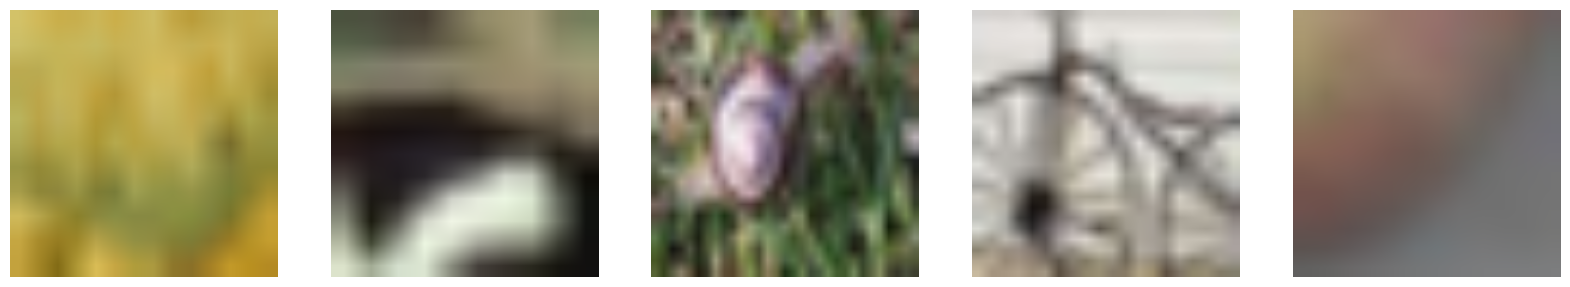

Before CutMix/MixUp: images.shape = torch.Size([4, 3, 224, 224]), labels.shape = torch.Size([4])


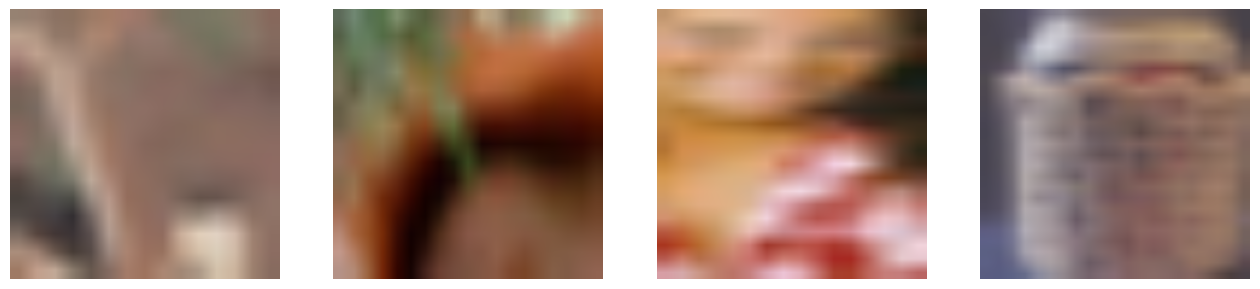

After CutMix/MixUp: images.shape = torch.Size([4, 3, 224, 224]), labels.shape = torch.Size([4])


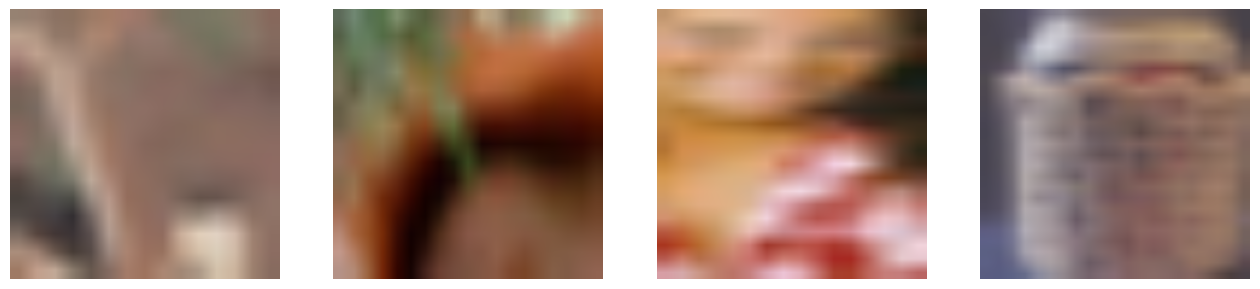

In [11]:
dm = CIFAR100DataModule(batch_size=4)
model = LightningClassifier('pytorch_resnet50', 100, lr=1e-3)

dm.setup('fit')

td = dm.cifar100_train
print(td[0][0].shape)
import utils.plotting_utils as plut
from utils.data_utils import denormm
plut.plot_hor([denormm(td[i][0].permute(1,2,0)) for i in range(5)])

tdl = dm.train_dataloader()

cutmix = v2.CutMix(num_classes=100)
mixup = v2.MixUp(num_classes=100)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

for images, labels in tdl:
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }")
    plut.plot_hor([denormm(i.permute(1,2,0)) for i in images])
    # images, labels = cutmix_or_mixup(images, labels)
    images = v2.ColorJitter(0,0,0)(images)
    print(f"After CutMix/MixUp: {images.shape = }, {labels.shape = }")
    plut.plot_hor([denormm(i.permute(1,2,0)) for i in images])
    break


In [6]:
i = len(dm.train_dataloader())

# train model
trainer = L.Trainer(max_epochs=50)
tuner = Tuner(trainer)
print('LR before:', model.lr)
lr_finder = tuner.lr_find(model, attr_name="lr", datamodule=dm, num_training=i)
print('LR after:', model.lr)

# fig = lr_finder.plot(suggest=True)
# fig.show()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LR before: 0.001
Files already downloaded and verified
0


Finding best initial lr:   0%|          | 0/313 [00:00<?, ?it/s]

0
309
310
0


`Trainer.fit` stopped: `max_steps=313` reached.
Learning rate set to 0.0007617090882816208
Restoring states from the checkpoint path at /Users/yinnnyou/workspace/medical_imaging_imbalancing/src/cifar_100/.lr_find_d5fbcb7e-f034-4a53-9c29-d1dd1feba676.ckpt
Restored all states from the checkpoint at /Users/yinnnyou/workspace/medical_imaging_imbalancing/src/cifar_100/.lr_find_d5fbcb7e-f034-4a53-9c29-d1dd1feba676.ckpt


LR after: 0.0007617090882816208


: 

In [ ]:
# trainer.fit(model, datamodule=dm)

### Timm

/root/miniconda3/envs/aaa/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name mixer_b16_224_in21k to current mixer_b16_224.goog_in21k_ft_in1k.
  model = create_fn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/root/miniconda3/envs/aaa/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


LR before: 0.001
Files already downloaded and verified


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.000363078054770101
Restoring states from the checkpoint path at /root/medical_imaging_imbalancing/src/cifar_100/.lr_find_0c11238d-ae1b-4fa0-b6e7-8e7bf975abd5.ckpt
Restored all states from the checkpoint at /root/medical_imaging_imbalancing/src/cifar_100/.lr_find_0c11238d-ae1b-4fa0-b6e7-8e7bf975abd5.ckpt


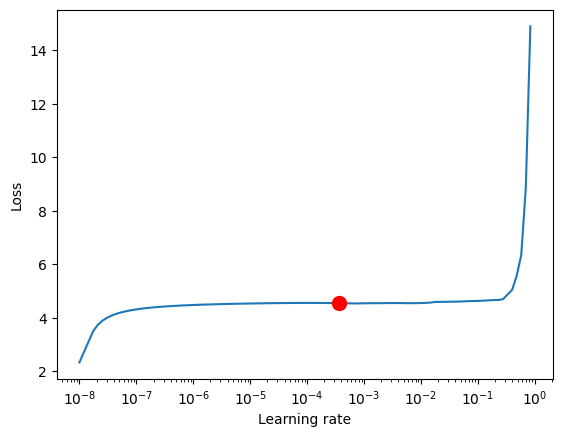

In [3]:
dm2 = CIFAR100DataModule(batch_size=64, data_dir='~/cifar-100')

model = LightningClassifier('timm_mixer_b16_224_in21k', 100)

# train model
trainer = L.Trainer()
tuner = Tuner(trainer)
print('LR before:', model.lr)
lr_finder = tuner.lr_find(model, attr_name="lr", datamodule=dm2)

# Plot with
# print('LR after:', model.lr)
fig = lr_finder.plot(suggest=True)
fig.show()
# trainer.fit(model=model, 
#             train_dataloaders=train_loader)

In [4]:
# trainer.fit(model, datamodule=dm2)

Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MlpMixer         | 59.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
59.2 M    Trainable params
0         Non-trainable params
59.2 M    Total params
236.753   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/root/miniconda3/envs/aaa/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
